In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Build quarterly date range
quarters = pd.period_range('2019Q1', '2024Q4', freq='Q')
n = len(quarters)

def make_company(name, base_rev, rev_trend, rev_vol, base_gm, gm_drift, gm_vol):
    # revenue: trend + noise
    revenue = base_rev * (1 + rev_trend) ** np.arange(n)
    revenue = revenue * (1 + np.random.normal(0, rev_vol, n))
    revenue = np.maximum(revenue, 1.0)

    # gross margin %: slow drift + noise, clipped to [20, 70]
    gm = base_gm + gm_drift * np.arange(n) + np.random.normal(0, gm_vol, n)
    gm = np.clip(gm, 20, 70)

    # opex %: gently mean-reverting around 20–25%
    opex = (22 + np.random.normal(0, 1.2, n)).clip(12, 32)

    df = pd.DataFrame({
        'company': name,
        'quarter': quarters.astype(str),
        'revenue_musd': revenue.round(2),
        'gross_margin_pct': gm.round(2),
        'opex_pct': opex.round(2)
    })
    return df

df_a = make_company('AAPLCo', base_rev=18000, rev_trend=0.02, rev_vol=0.05,
                    base_gm=42, gm_drift=0.05, gm_vol=1.4)
df_b = make_company('BetaBank', base_rev=9000, rev_trend=0.025, rev_vol=0.06,
                    base_gm=37, gm_drift=-0.03, gm_vol=1.6)

data = pd.concat([df_a, df_b], ignore_index=True)

# Derived metrics
data['cogs_musd'] = (data['revenue_musd'] * (1 - data['gross_margin_pct']/100)).round(2)
data['gross_profit_musd'] = (data['revenue_musd'] - data['cogs_musd']).round(2)
data['opex_musd'] = (data['revenue_musd'] * data['opex_pct']/100).round(2)
data['op_income_musd'] = (data['gross_profit_musd'] - data['opex_musd']).round(2)
data['op_margin_pct'] = (100 * data['op_income_musd'] / data['revenue_musd']).round(2)

# Save the sample file
data.to_csv('financial_demo_quarterly.csv', index=False)
data.head(10)


,company,quarter,revenue_musd,gross_margin_pct,opex_pct,cogs_musd,gross_profit_musd,opex_musd,op_income_musd,op_margin_pct
0,AAPLCo,2019Q1,18447.04,41.24,22.41,10839.48,7607.56,4133.98,3473.58,18.83
1,AAPLCo,2019Q2,18233.07,42.21,19.88,10536.89,7696.18,3624.73,4071.45,22.33
2,AAPLCo,2019Q3,19333.67,40.49,22.39,11505.47,7828.20,4328.81,3499.39,18.10
3,AAPLCo,2019Q4,20556.37,42.68,21.54,11782.91,8773.46,4427.84,4345.62,21.14
4,AAPLCo,2020Q1,19255.67,41.36,21.19,11291.52,7964.15,4080.28,3883.87,20.17
5,AAPLCo,2020Q2,19640.80,41.84,22.73,11423.09,8217.71,4464.35,3753.36,19.11
6,AAPLCo,2020Q3,21871.53,41.46,23.24,12803.59,9067.94,5082.94,3985.00,18.22
7,AAPLCo,2020Q4,21469.73,44.94,23.12,11821.23,9648.50,4963.80,4684.70,21.82
8,AAPLCo,2021Q1,20594.81,42.38,20.99,11866.73,8728.08,4322.85,4405.23,21.39
9,AAPLCo,2021Q2,22095.23,40.97,21.63,13042.81,9052.42,4779.20,4273.22,19.34


In [2]:
import pandas as pd

df = pd.read_csv('financial_demo_quarterly.csv')
df['period'] = pd.PeriodIndex(df['quarter'], freq='Q').to_timestamp('Q')

# Sort and compute YoY deltas by company
df = df.sort_values(['company','period']).reset_index(drop=True)
df['revenue_yoy_%'] = df.groupby('company')['revenue_musd'].pct_change(4) * 100
df['gm_yoy_pp']    = df.groupby('company')['gross_margin_pct'].diff(4)  # percentage points

# Define "margin squeeze": revenue up YoY but GM down YoY
df['margin_squeeze'] = (df['revenue_yoy_%'] > 0) & (df['gm_yoy_pp'] < 0)

interesting = (df[df['margin_squeeze']]
               .loc[:, ['company','quarter','revenue_musd','gross_margin_pct','revenue_yoy_%','gm_yoy_pp']]
               .sort_values(['company','quarter']))

print("Margin squeeze quarters (revenue ↑ YoY, gross margin ↓ YoY):")
display(interesting.head(10))


Margin squeeze quarters (revenue ↑ YoY, gross margin ↓ YoY):


,company,quarter,revenue_musd,gross_margin_pct,revenue_yoy_%,gm_yoy_pp
5,AAPLCo,2020Q2,19640.80,41.84,7.720751,-0.37
9,AAPLCo,2021Q2,22095.23,40.97,12.496589,-0.87
11,AAPLCo,2021Q4,21859.57,40.84,1.815766,-4.10
14,AAPLCo,2022Q3,21702.22,40.84,1.253786,-2.81
19,AAPLCo,2023Q4,24370.89,42.53,3.509731,-0.50
20,AAPLCo,2024Q1,28707.14,40.93,22.372689,-2.90
21,AAPLCo,2024Q2,26974.01,42.04,5.365704,-1.05
22,AAPLCo,2024Q3,27921.59,42.46,13.774161,-0.28
28,BetaBank,2020Q1,9986.20,34.62,11.196851,-2.85
30,BetaBank,2020Q3,10494.70,36.27,31.688281,-0.68


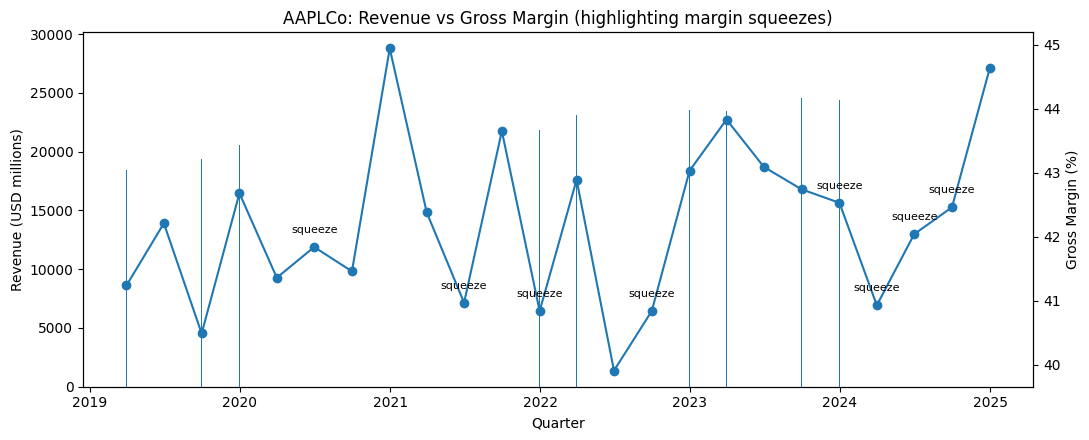

In [3]:
import matplotlib.pyplot as plt

company = 'AAPLCo'   # change to 'BetaBank' if you like
sub = df[df['company'] == company].copy()

fig, ax1 = plt.subplots(figsize=(11,4.5))

# Revenue (bars)
ax1.bar(sub['period'], sub['revenue_musd'])
ax1.set_ylabel('Revenue (USD millions)')
ax1.set_xlabel('Quarter')
ax1.set_title(f'{company}: Revenue vs Gross Margin (highlighting margin squeezes)')

# Gross margin (line) on secondary axis
ax2 = ax1.twinx()
ax2.plot(sub['period'], sub['gross_margin_pct'], marker='o')
ax2.set_ylabel('Gross Margin (%)')

# Annotate squeeze quarters
squeezes = sub[sub['margin_squeeze']]
for _, r in squeezes.iterrows():
    ax2.annotate('squeeze',
                 xy=(r['period'], r['gross_margin_pct']),
                 xytext=(0,10),
                 textcoords='offset points',
                 ha='center', fontsize=8)

fig.tight_layout()
plt.show()
